In [93]:
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')
from IPython.display import Javascript
display(Javascript('IPython.notebook.execute_cells_above()'))

<IPython.core.display.Javascript object>

In [199]:
import matplotlib.pyplot as plt
import numpy as np 
import os
from pathlib import Path 
import pandas as pd 
import seaborn as sns
from sklearn.neural_network import MLPRegressor

plt.style.use('ggplot')

DATA_DIR = Path("../../data")
JOKES_DIR = DATA_DIR / "jokes"
BERT_EMBEDDINGS = DATA_DIR / "bert_embeddings"
FASTTEXT_EMBEDDINGS = DATA_DIR / "fasttext_embeddings"

In [95]:
NAN = 99

In [96]:
ratings_path = DATA_DIR / 'jester-data-1.xls'
xl = pd.ExcelFile(ratings_path)
print(xl.sheet_names)
ratings = xl.parse(xl.sheet_names[0], header=None)
ratings = ratings.loc[:, 1:]

['jester-data-1-new']


## Analiza Danych

Oceny żartów są z przedziału [-10, 10], jednak w danych występuje też wartość 99, która oznacza brak oceny. Pierwsza kolumna oznacza ilość wystawionych przez użytkownika ocen, jednak ta informacja zdaje się zbędna w kontekście problemu, bo nie chcemy uczyć modelu konkretnie dla tego zbioru żartów, tak więc ta kolumna zostanie usunięta.

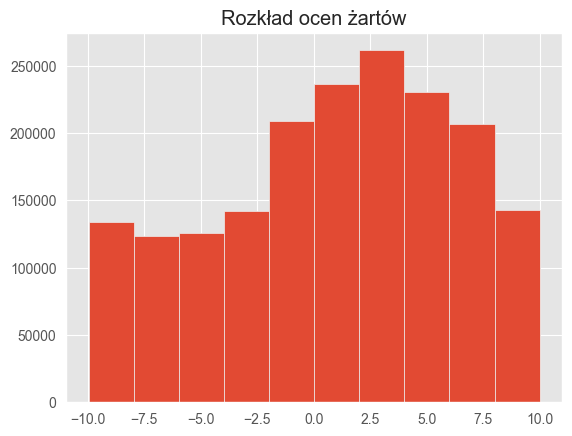

In [97]:
plt.title('Rozkład ocen żartów')
_ = plt.hist(ratings[ratings < NAN].values.flatten())

Około 28% ocen to wartości puste

In [98]:
np.round(np.sum(np.sum(ratings >= NAN)) / ratings.size, 2)

0.28

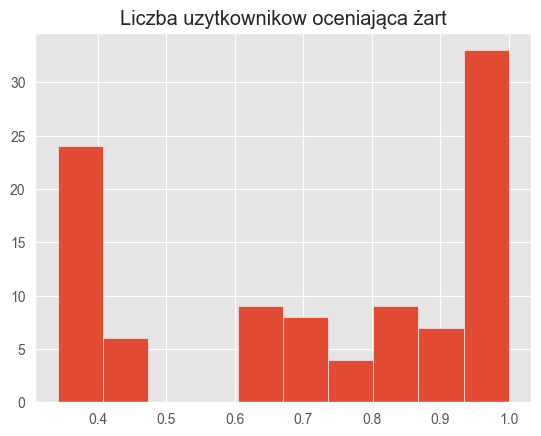

In [99]:
users_ratio_per_jokes_ratings = np.sum(ratings < NAN) / ratings.shape[0]
plt.title('Liczba uzytkownikow oceniająca żart')
_ = plt.hist(users_ratio_per_jokes_ratings)

In [100]:
user_group_ratings = pd.cut(users_ratio_per_jokes_ratings, bins=5, labels=['< 20%', '20 - 40%', '40 - 60%', '60 - 80%', '80 - 100%'])

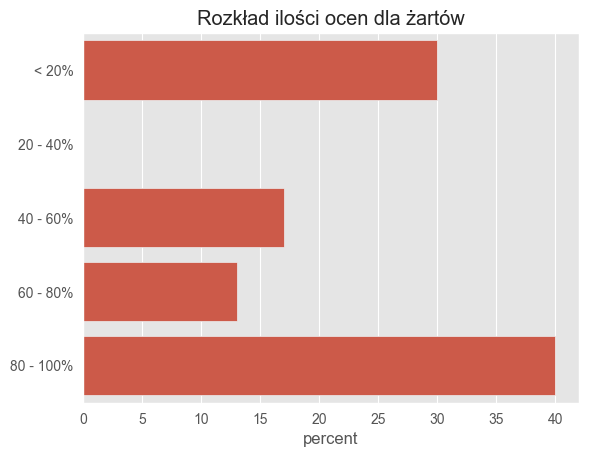

In [101]:
plt.title('Rozkład ilości ocen dla żartów')
_ = sns.countplot(user_group_ratings, stat='percent')

Ważne jest to, by podczas obliczania średniej oceny nie brać pod uwagę ocen o wartości 99

In [120]:
ratings_description = ratings[ratings < NAN].describe().transpose()
ratings_description['% user'] = users_ratio_per_jokes_ratings
ratings_description['% user cat'] = user_group_ratings

In [121]:
ratings_description = ratings_description.reset_index().rename({'index': 'joke_id'}, axis=1).set_index(np.arange(1, 101))

In [122]:
ratings_description.head()

,joke_id,count,mean,std,min,25%,50%,75%,max,% user,% user cat
1,1,16452.0,0.904573,5.171798,-9.95,-2.67,1.60,4.90,9.37,0.658528,40 - 60%
2,2,18184.0,0.208460,5.597327,-9.95,-4.42,0.83,4.82,9.37,0.727855,40 - 60%
3,3,16642.0,0.316574,5.399806,-9.95,-4.03,0.78,4.66,9.37,0.666133,40 - 60%
4,4,15608.0,-1.449114,5.234654,-9.95,-5.87,-1.46,2.52,9.37,0.624745,40 - 60%
5,5,24977.0,0.403556,5.255700,-9.95,-3.69,1.12,4.47,9.37,0.999760,80 - 100%


Obserwacje: 
- średnie oceny wahają się w przedziale [-4, 4]
- odchylenia standardowe są dosyć duże (w kontekście zakresu ocen) - w przedziale [4, 6]
- ocena i średnia zdają się być trochę większe dla żartów mniej ocenianych
- minimalna ocena jest praktycznie taka sama dla wszystkich żartów
- maksymalna ma trochę bardziej różnorodny rozkład, chociaż mocno stronniczy

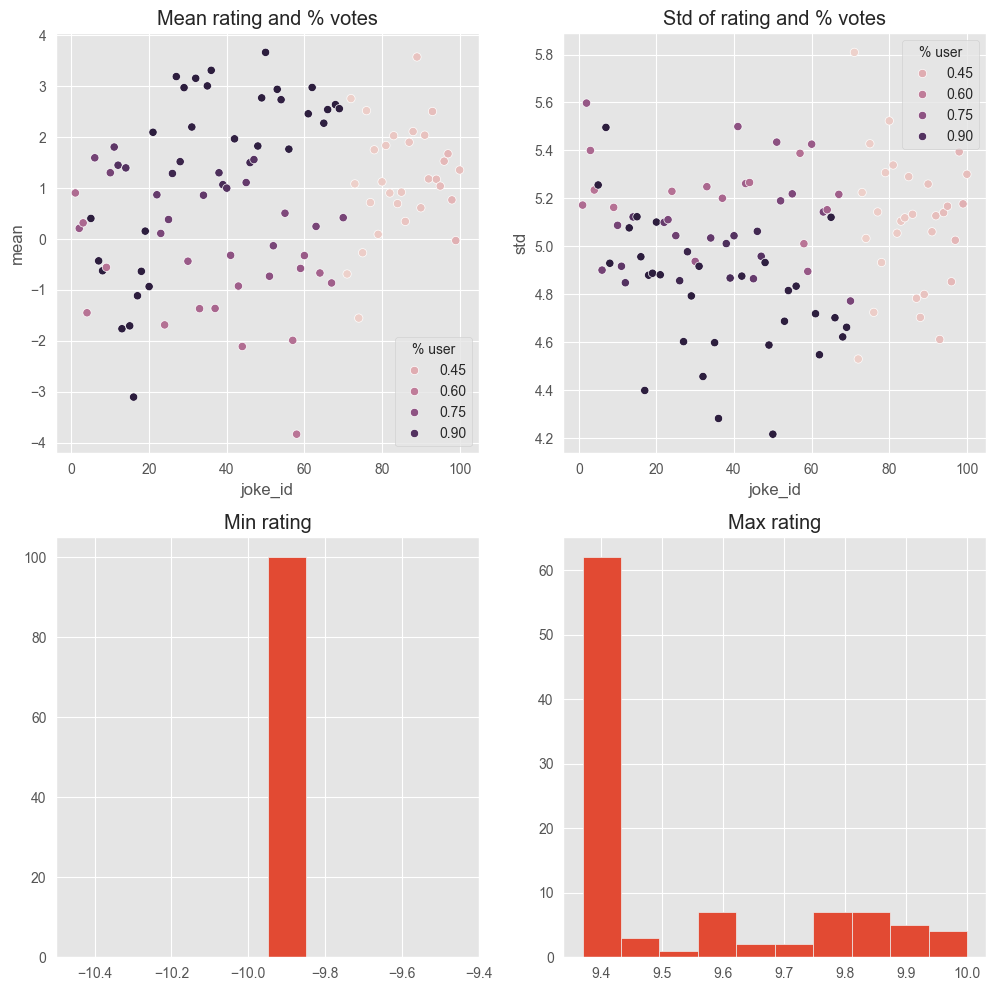

In [123]:
plt.figure(figsize=(12, 12))
plt.subplot(2, 2, 1, title='Mean rating and % votes')
sns.scatterplot(ratings_description, x='joke_id', y='mean', hue='% user')
plt.subplot(2, 2, 2, title='Std of rating and % votes')
sns.scatterplot(ratings_description, x='joke_id', y='std', hue='% user')
plt.subplot(2, 2, 3, title='Min rating')
plt.hist(ratings_description['min'])
plt.subplot(2, 2, 4, title='Max rating')
_ = plt.hist(ratings_description['max'])

In [106]:
ratings_description['mean - median'] = ratings_description['mean'] - ratings_description['50%']

W przypadku mediany możemy zauważyć, że podobnie rozkłada się ona w przedziale [-4, 4], natomiast różnica między średnią a medianą jest w większości poniżej 0. 

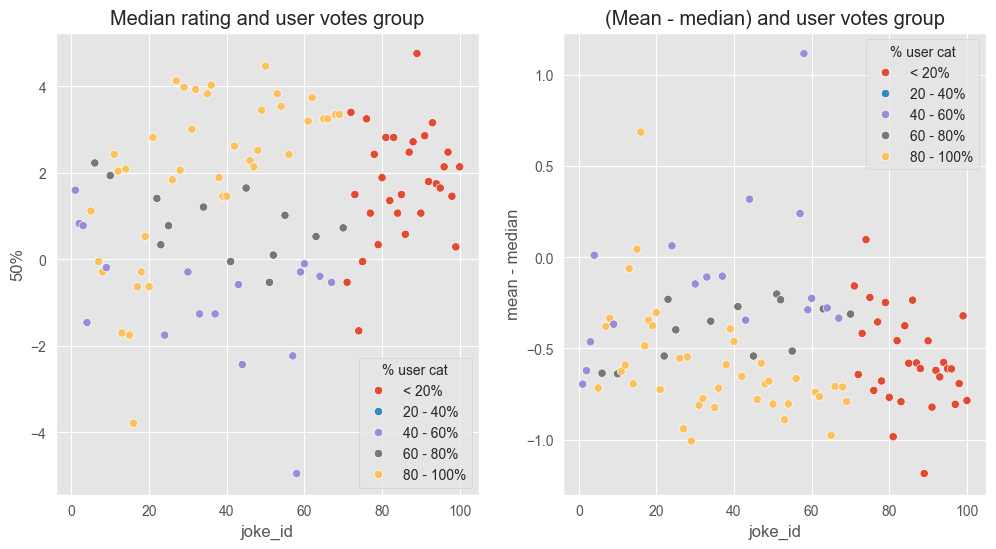

In [107]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1, title='Median rating and user votes group')
sns.scatterplot(ratings_description, x='joke_id', y='50%', hue='% user cat')
plt.subplot(1, 2, 2, title='(Mean - median) and user votes group')
_ = sns.scatterplot(ratings_description, x='joke_id', y='mean - median', hue='% user cat')

(array([32.,  7.,  1.,  0.,  2.,  2.,  0.,  0.,  0., 14.]),
 array([-9.66 , -7.951, -6.242, -4.533, -2.824, -1.115,  0.594,  2.303,
         4.012,  5.721,  7.43 ]),
 <BarContainer object of 10 artists>)

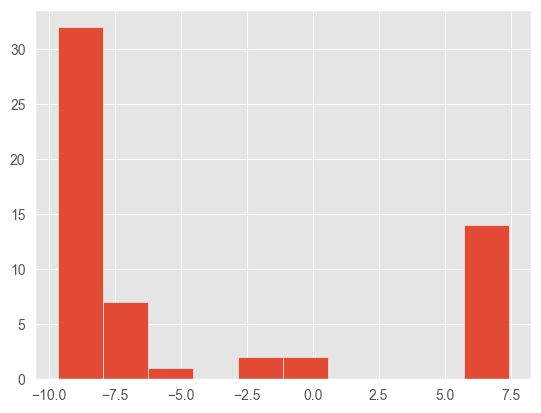

In [108]:
plt.hist(ratings.loc[58, ratings[58] < NAN])

<Axes: >

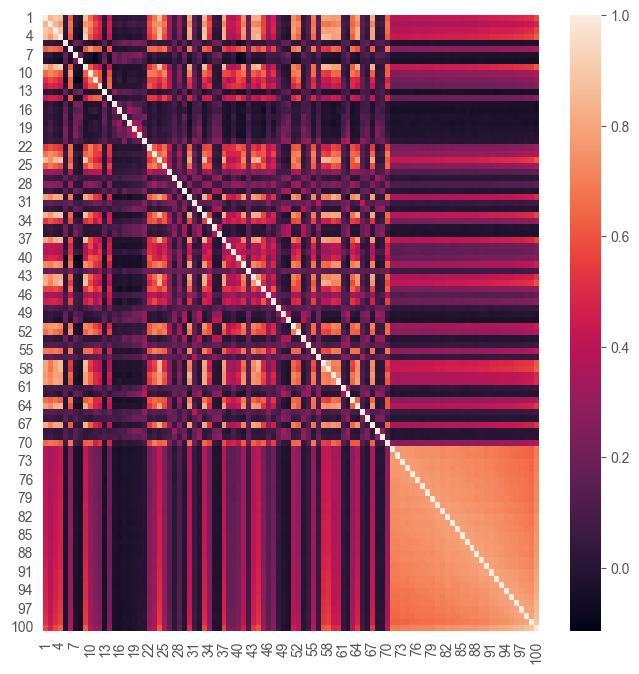

In [110]:
correlation_matrix = ratings.corr()
plt.figure(figsize=(8, 8))
sns.heatmap(correlation_matrix, annot=False)

In [111]:
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.decomposition import TruncatedSVD
svd = TruncatedSVD(n_components=50)
latent_matrix = svd.fit_transform(ratings)

Macierz podobieństwa kosinusowego wg. ocen żartów przez użytkowników - podobieństwa między ocenami różnych żartów dla tych samych użytkowników

In [ ]:
joke_similarity = cosine_similarity(ratings.T)
plt.figure(figsize=(8, 8))
sns.heatmap(joke_similarity, annot=False)
plt.show()

### Preprocessing danych
Na wejściu do sieci najlepiej będzie podać znormalizowane dane z usunięciem wartości pustych, czyli tych bez oceny.
Dane będą w postaci długiej, gdzie każdy wiersz będzie odpowiadał ocenie jednego żartu przez jednego użytkownika

In [224]:
normalized_ratings = ratings[ratings < NAN]

In [209]:
# normalized_ratings = (ratings[ratings < NAN] - ratings_description['min']) / (ratings_description['max'] - ratings_description['min'])

In [158]:
# normalized_ratings = (ratings[ratings < NAN] - ratings_description['mean']) / ratings_description['std']

In [225]:
normalized_ratings

,1,2,3,4,5,6,7,8,9,10,...,91,92,93,94,95,96,97,98,99,100
0,-7.82,8.79,-9.66,-8.16,-7.52,-8.50,-9.85,4.17,-8.98,-4.76,...,2.82,NaN,NaN,NaN,NaN,NaN,-5.63,NaN,NaN,NaN
1,4.08,-0.29,6.36,4.37,-2.38,-9.66,-0.73,-5.34,8.88,9.22,...,2.82,-4.95,-0.29,7.86,-0.19,-2.14,3.06,0.34,-4.32,1.07
2,NaN,NaN,NaN,NaN,9.03,9.27,9.03,9.27,NaN,NaN,...,NaN,NaN,NaN,9.08,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,8.35,NaN,NaN,1.80,8.16,-2.82,6.21,NaN,1.84,...,NaN,NaN,NaN,0.53,NaN,NaN,NaN,NaN,NaN,NaN
4,8.50,4.61,-4.17,-5.39,1.36,1.60,7.04,4.61,-0.44,5.73,...,5.19,5.58,4.27,5.19,5.73,1.55,3.11,6.55,1.80,1.60
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24978,0.44,7.43,9.08,2.33,3.20,6.75,-8.79,-0.53,-8.74,7.23,...,8.83,-1.21,9.22,-6.70,8.45,9.03,6.55,8.69,8.79,7.43
24979,9.13,-8.16,8.59,9.08,0.87,-8.93,-3.50,5.78,-8.11,4.90,...,-1.17,-5.73,-1.46,0.24,9.22,-8.20,-7.23,-8.59,9.13,8.45
24980,NaN,NaN,NaN,NaN,-7.77,NaN,6.70,-6.75,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
24981,NaN,NaN,NaN,NaN,-9.71,NaN,4.56,-8.30,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [226]:
preprocessed_ratings = normalized_ratings.melt(ignore_index=False).reset_index().rename(columns={'variable': 'joke_id', 'value': 'rating', 'index': 'user_id'}).dropna()

In [227]:
preprocessed_ratings[preprocessed_ratings['user_id'] == 1]

,user_id,joke_id,rating
1,1,1,4.08
24984,1,2,-0.29
49967,1,3,6.36
74950,1,4,4.37
99933,1,5,-2.38
...,...,...,...
2373386,1,96,-2.14
2398369,1,97,3.06
2423352,1,98,0.34
2448335,1,99,-4.32


In [228]:
preprocessed_ratings.shape

(1810455, 3)

In [236]:
from sklearn.model_selection import train_test_split
ratings_train, ratings_test = train_test_split(preprocessed_ratings, stratify=preprocessed_ratings['joke_id'])
ratings_train, _ = train_test_split(ratings_train, stratify=ratings_train['joke_id'], test_size=0.8)

In [237]:
ratings_train.shape

(271568, 3)

## Wektory osadzone żartów 

In [238]:
bert_embeds = np.zeros((101, 768))

In [239]:
for f in os.listdir(BERT_EMBEDDINGS):
    joke_num = int(f.split(".")[0][4:])
    bert_embeds[joke_num] = np.load(BERT_EMBEDDINGS / f)

In [240]:
def create_dataset(embeddings, ratings):
    # X are embeddings 
    # y are ratings 
    X = pd.DataFrame(embeddings.astype(np.float32))
    embeddings_cols = X.columns
    merged = pd.merge(ratings, X, left_on='joke_id', right_index=True)
    X = merged[embeddings_cols]
    y = merged['rating']
    return X, y

In [241]:
X_train, y_train = create_dataset(bert_embeds, ratings_train)

In [242]:
X_test, y_test = create_dataset(bert_embeds, ratings_test)

## Model

In [244]:
mlp = MLPRegressor(hidden_layer_sizes=[100], 
                       random_state=42, verbose=True, batch_size=64).fit(X_train, y_train)

Iteration 1, loss = 12.58533102
Iteration 2, loss = 12.51593148
Iteration 3, loss = 12.50371798
Iteration 4, loss = 12.49622709
Iteration 5, loss = 12.49329100
Iteration 6, loss = 12.48780018


In [204]:
mlp.predict(X_test)

array([0.00419472, 0.00419472, 0.00419472, ..., 0.00419472, 0.00419472,
       0.00419472], dtype=float32)